In [1]:
# Scan SOL10111

In [2]:
from impact import Impact, run_impact_with_distgen
from distgen import Generator

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

In [3]:
# Allows processes to work with macOS
from sys import platform
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")

# Initial setup and test

In [4]:
G = Generator('$FACET2_LATTICE/distgen/models/f2e_inj/v0/distgen.yaml')
G['n_particle']= 10000
G.run()
P0 = G.particles
P0

<ParticleGroup with 10000 particles at 0x1626b8e20>

In [5]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.stop

12.0

In [5]:
I0 = Impact.from_yaml('v0/ImpactT.yaml')
I0.verbose=True

I0.stop = 4.2
I0.run()

Removed element: stop_1
Set stop to s = 0.4
Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp_1punnpu
/Users/chrisonian/Code/impact/impactT/bin/ImpactTv2.1_serial
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: 2.1 beta version
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           23          23
 pass setting up lattice...
 check randomness:            0  0.30440529327431320     
 avgpts, jlow, and jhigh:        10000           1       10000
 sumx1,sumy1:   -1.8066737280999832E-005  -1.3380017915800005E-005
 pass generating initial distribution...
 tstop:   0.40000000000000002     
 i,t,<z>:            1   0.0000000000000000        0.0000000000000000     
 zmin,zmax:    0.0000000000000000        5.2901005912554106E-006
 name: rfdataxrfdataxxrfdata201
 time:    0.0000000000000000, elapsed: 164.15774631500244Finished.

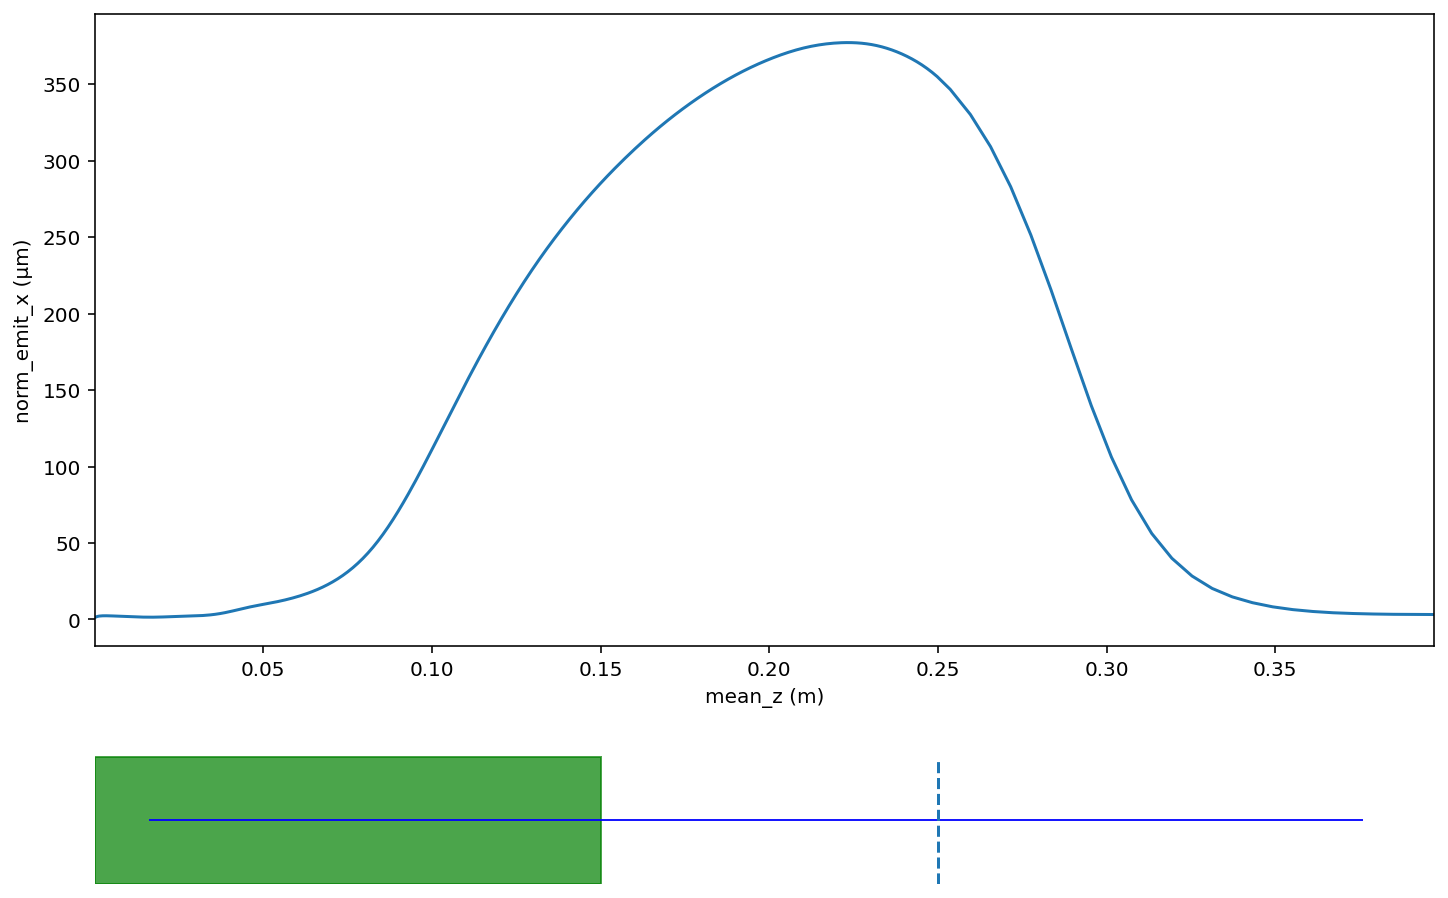

In [6]:
I0.plot('norm_emit_x')

In [7]:
I0['SOL10111:solenoid_field_scale']

0.23

In [27]:
I0['GUNF_phase:dtheta0_deg']

0

In [14]:
%%time

ZSTOP = 4.1

def set_attr(key, val):
    I = Impact.from_yaml('v0/ImpactT.yaml')
    I.initial_particles = P0
    I[key] = val
    I.stop = ZSTOP
    I.run()
    return I
    


CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 10 µs


# Scan `SOL10111:solenoid_field_scale`

# Parallel

In [7]:
from concurrent.futures import ProcessPoolExecutor

In [8]:
# Scan list
xlist = np.linspace(0.24, 0.28, 4)
xlist 

array([0.24      , 0.25333333, 0.26666667, 0.28      ])

In [9]:
%%time

# Have to define like this - lambdas do not work. 
def set1(val):
    return set_attr('SOL10111:solenoid_field_scale', val)

with ProcessPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(set1, xlist))

CPU times: user 48.1 ms, sys: 66.9 ms, total: 115 ms
Wall time: 6min 11s


0.24 1071
0.25333333333333335 1071
0.26666666666666666 1071
0.28 1071


Text(0, 0.5, 'norm_emit_x (mm-mrad)')

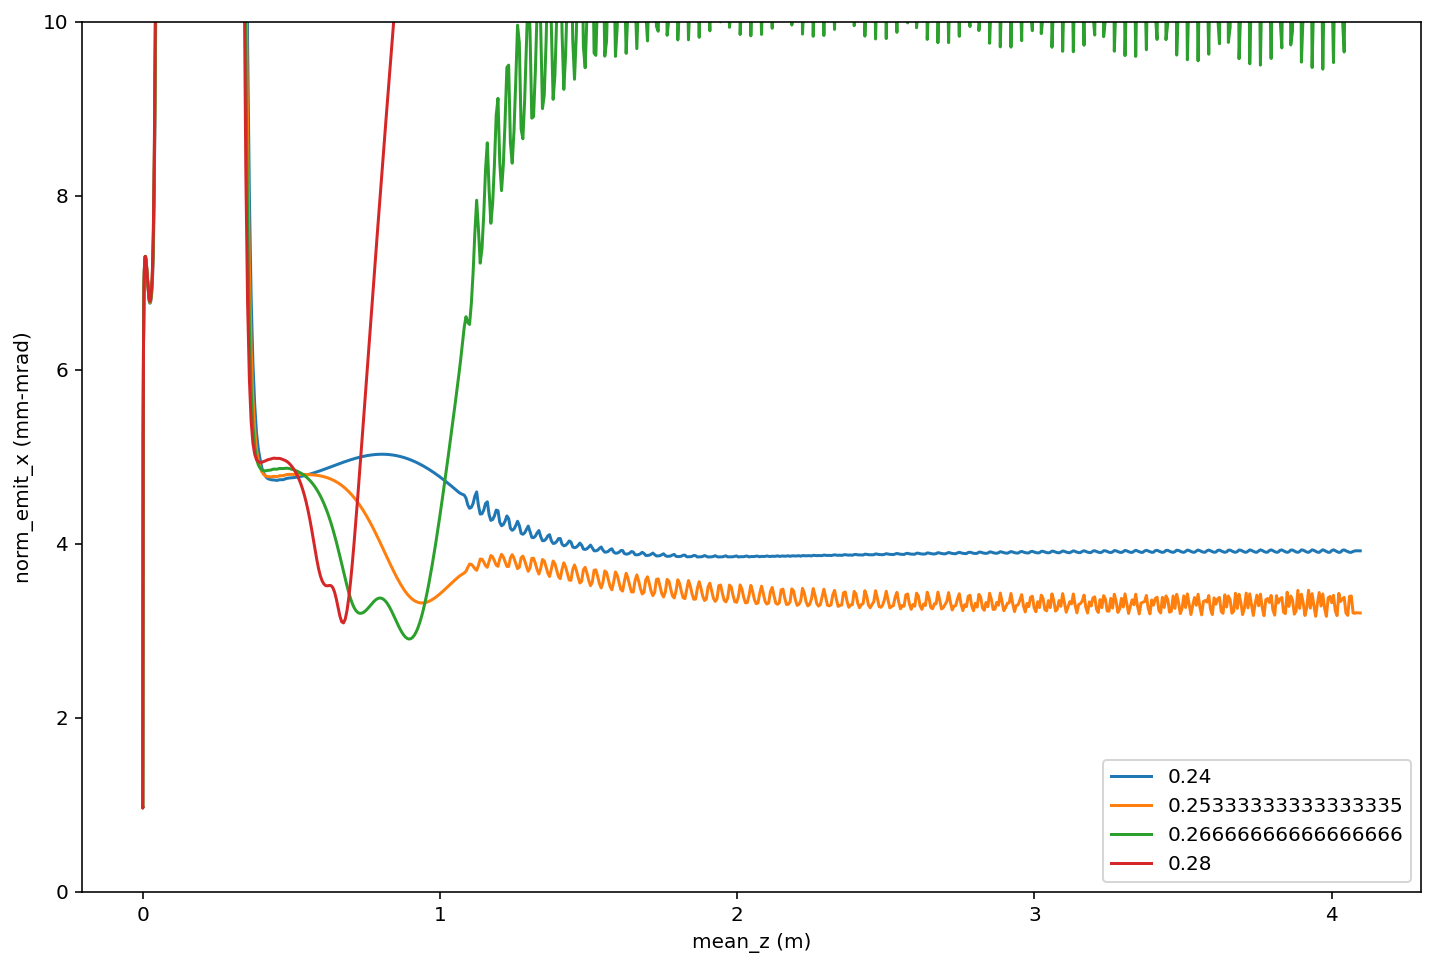

In [10]:
fig, ax = plt.subplots()

k1 = 'mean_z'
k2 = 'norm_emit_x'

f1 = 1
f2 = 1e6

for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)
    
ax.set_ylim(0, 10)    
ax.legend()    
ax.set_xlabel(k1 + ' (m)')
ax.set_ylabel(k2 + ' (mm-mrad)')
    

In [11]:
for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)

0.24 1071
0.25333333333333335 1071
0.26666666666666666 1071
0.28 1071


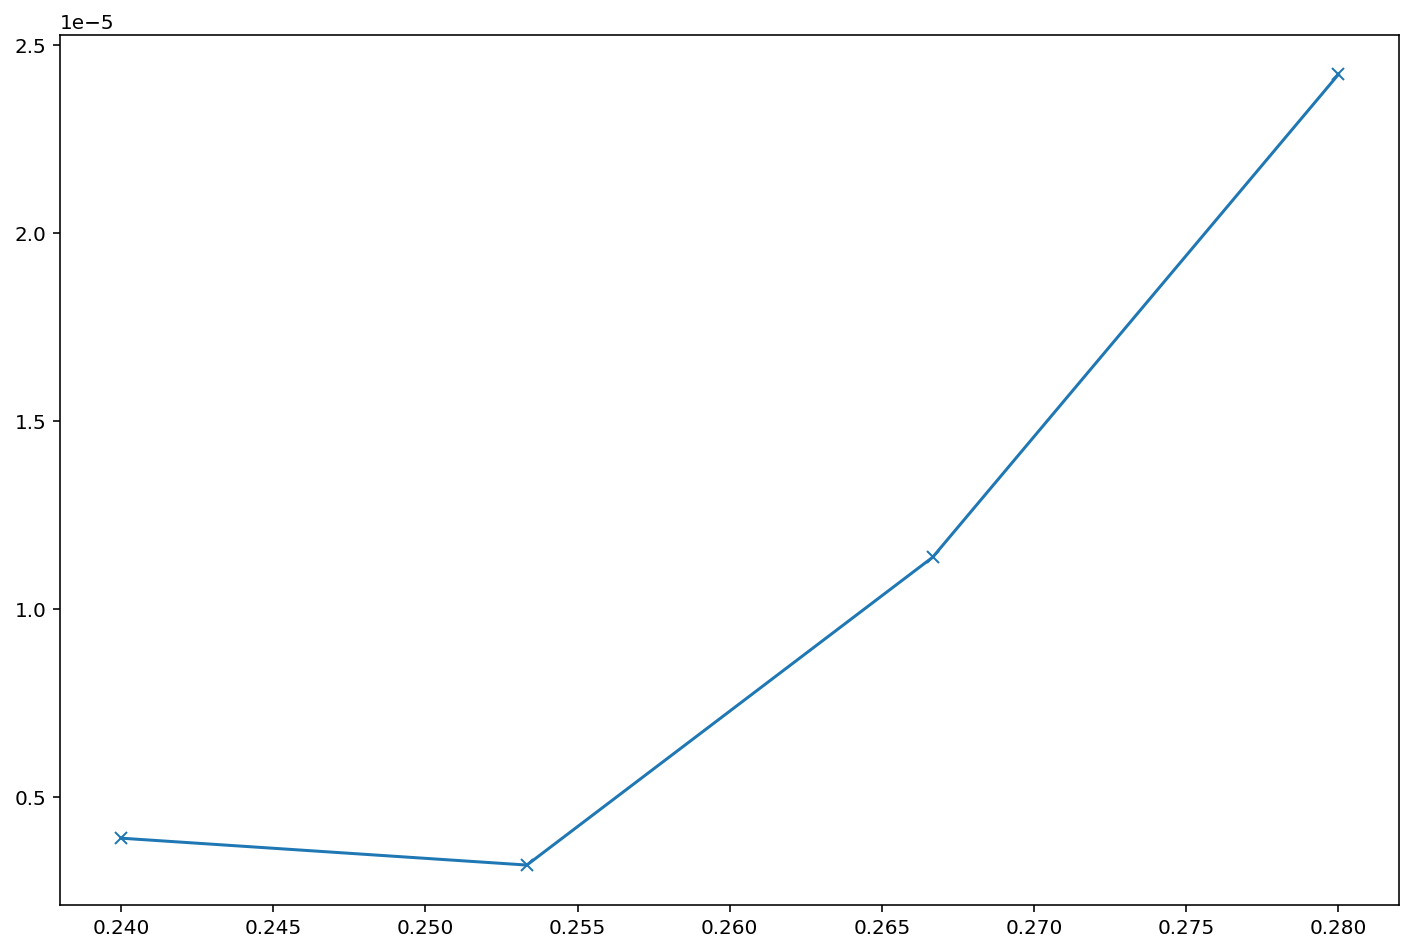

In [13]:
emits = [I.stat('norm_emit_x')[-1] for I in results]

plt.plot(xlist, emits, marker='x')

# Scan GUNF phase

In [15]:

ZSTOP = 0.2

#KEY = 'L0AF_phase:dtheta0_deg'
KEY = 'GUNF_phase:dtheta0_deg'

# Scan list
xlist = np.linspace(-40,0, 5)
xlist 

array([-40., -30., -20., -10.,   0.])

In [16]:
%%time


# Have to define like this - lambdas do not work. 
def set1(val):
    return set_attr(KEY, val)

with ProcessPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(set1, xlist))

CPU times: user 110 ms, sys: 97.6 ms, total: 208 ms
Wall time: 3min 1s


-40.0 81
-30.0 361
-20.0 359
-10.0 357
0.0 356


Text(0, 0.5, 'mean_kinetic_energy (mm-mrad)')

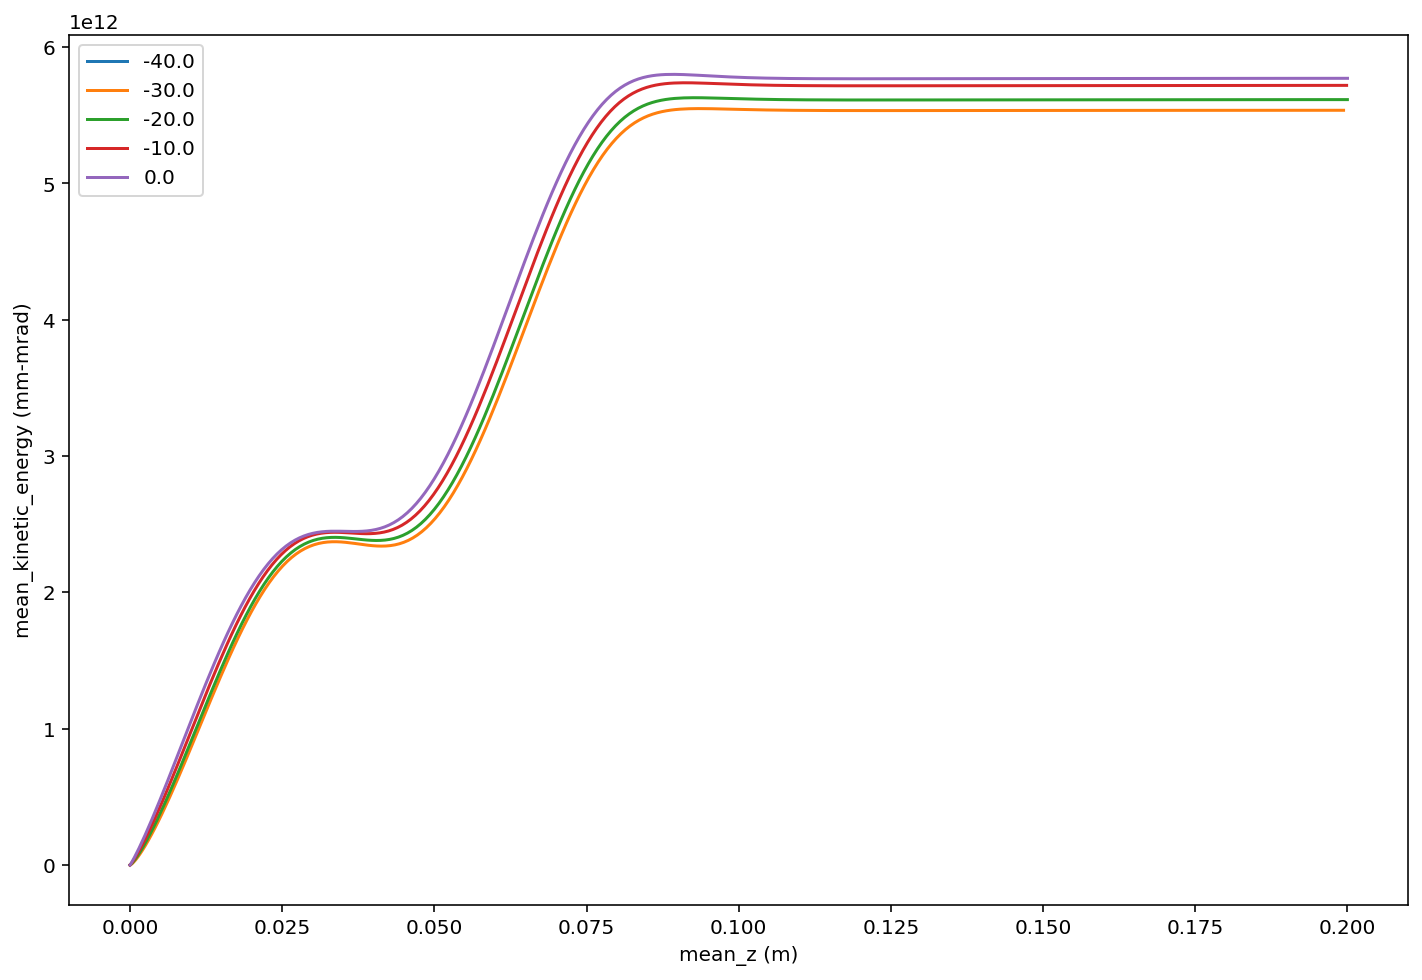

In [17]:
fig, ax = plt.subplots()

k1 = 'mean_z'
k2 = 'mean_kinetic_energy'

f1 = 1
f2 = 1e6

for dt, I in zip(xlist, results):
    
    x = I.stat(k1)*f1
    y = I.stat(k2)*f2
    print(dt, len(y))
    ax.plot(x, y, label=dt)
    
#ax.set_ylim(0, 10)    
ax.legend()    
ax.set_xlabel(k1 + ' (m)')
ax.set_ylabel(k2 + ' (mm-mrad)')
    

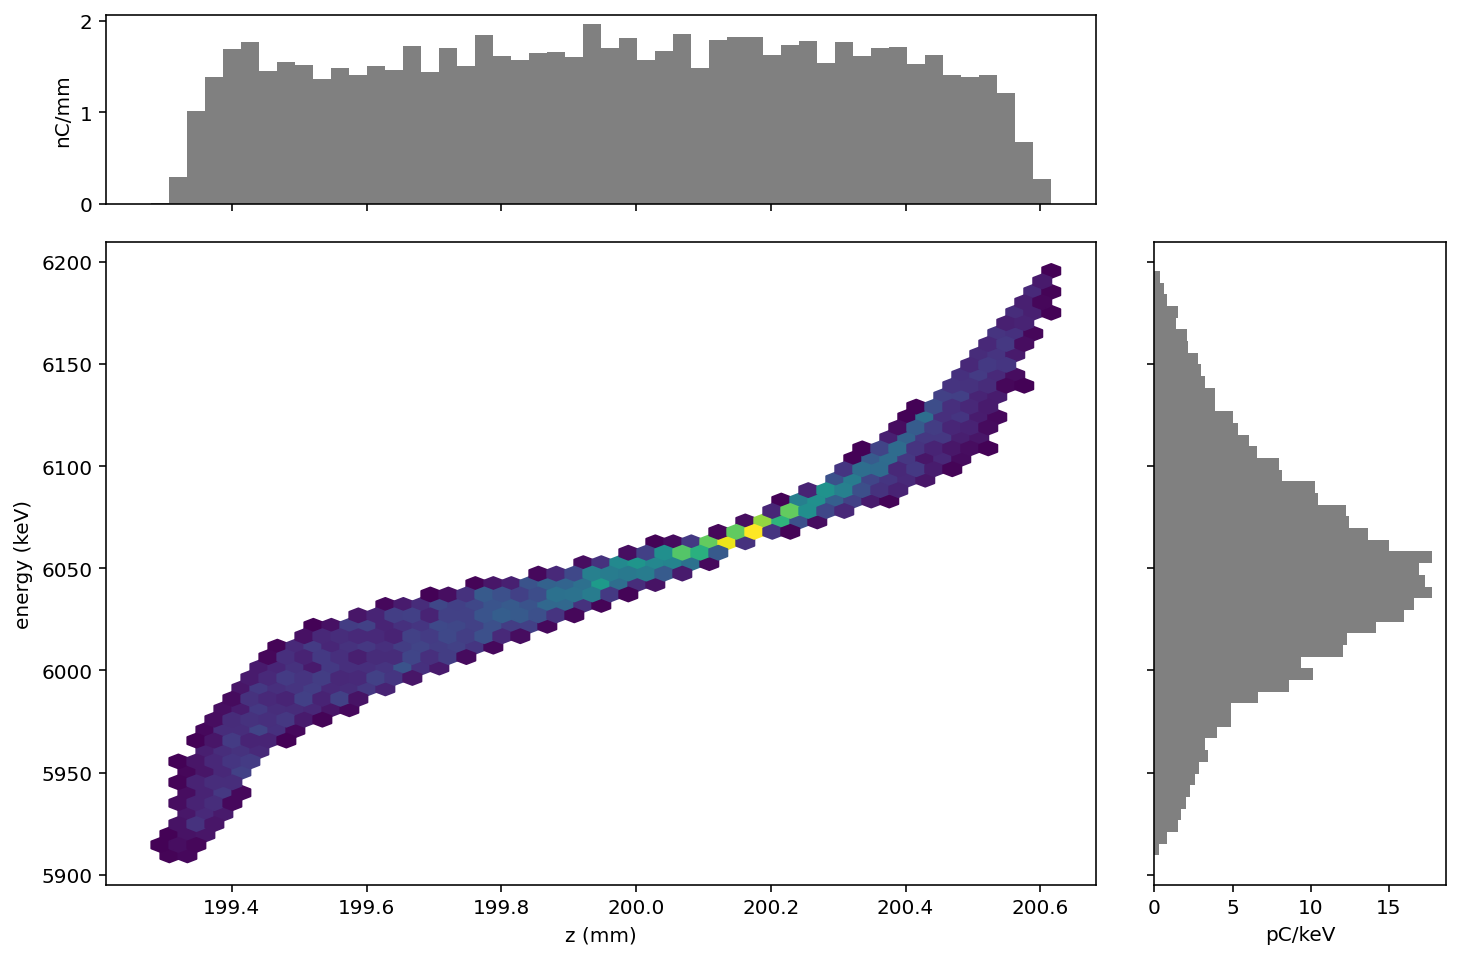

In [18]:
results[1].particles['final_particles'].plot('z', 'energy')

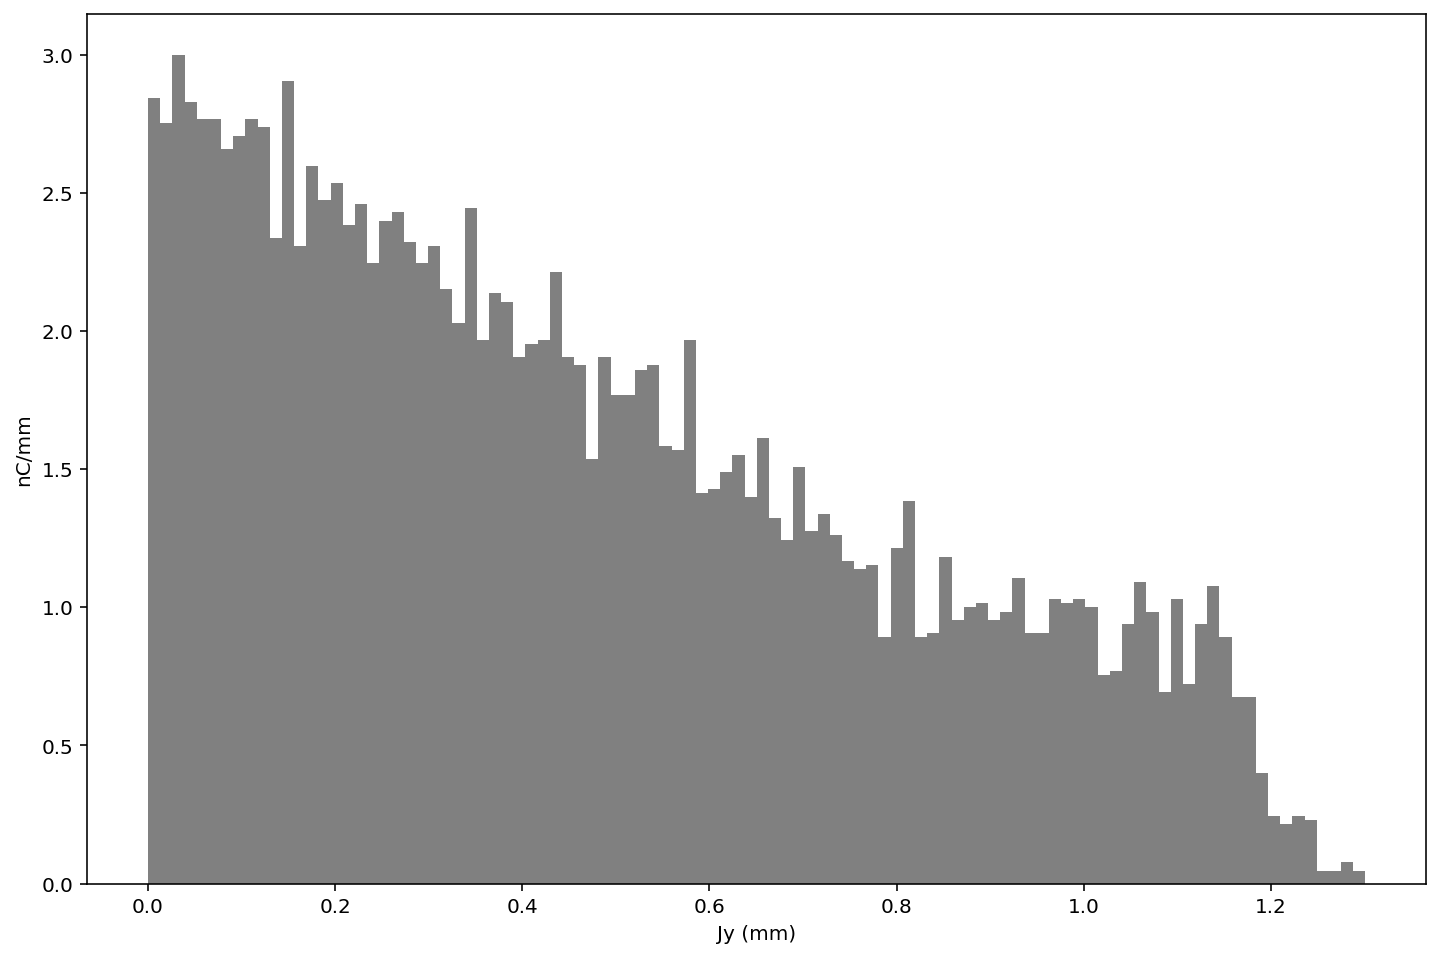

In [19]:
results[1].particles['final_particles'].plot('Jy')

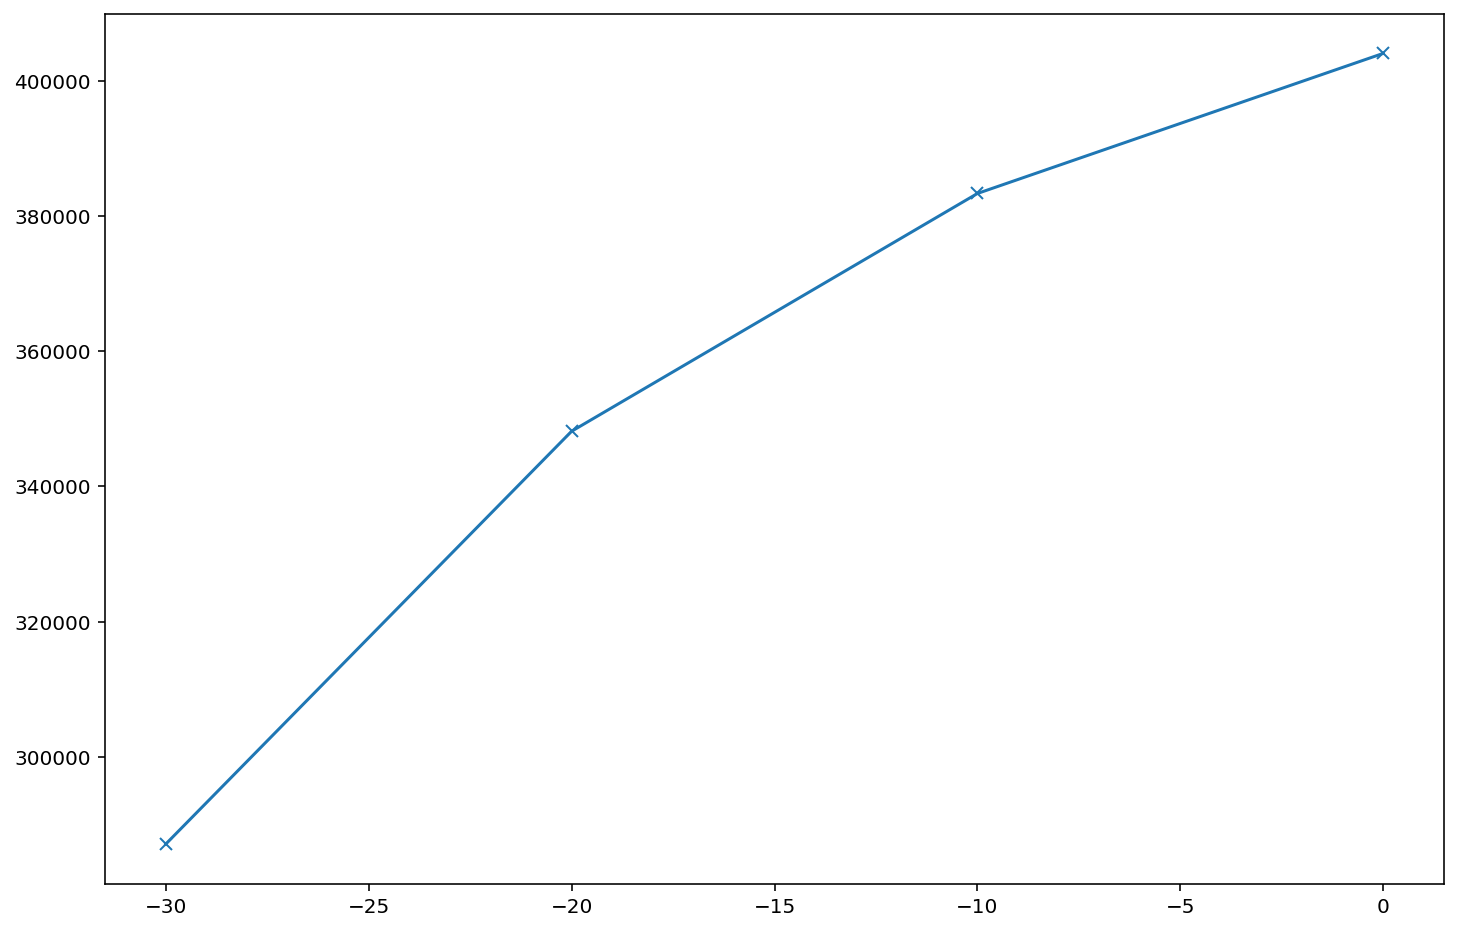

In [20]:
vals = [I.particles['final_particles'].p.ptp() for I in results[1:]]

plt.plot(xlist[1:], vals, marker='x')

In [66]:
I.particles['final_particles'].Jy

array([0.0002245 , 0.00102816, 0.00050792, ..., 0.00086397, 0.00037582,
       0.00144046])